<a href="https://colab.research.google.com/github/chandan-n-max/ola_business_case_study/blob/main/Ola_BCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# STEP 0: Upload CSV file and import libraries

# 1) Upload the CSV file from your system
from google.colab import files
uploaded = files.upload()   # choose ola_driver_scaler.csv when prompted

import io
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# 2) Read the uploaded CSV (takes first uploaded file)
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())


Saving ola_driver_scaler.csv to ola_driver_scaler.csv
Shape: (19104, 14)
Columns: ['Unnamed: 0', 'MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City', 'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation', 'Grade', 'Total Business Value', 'Quarterly Rating']


In [2]:
# STEP 1: Basic EDA – structure, missing values, summary

print("Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nStatistical summary of numeric columns:")
display(df.describe())


Shape: (19104, 14)

First 5 rows:


,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB
None



,Unnamed: 0,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
count,19104.000000,19104.000000,19043.000000,19052.000000,19104.000000,19104.000000,19104.000000,19104.000000,1.910400e+04,19104.000000
mean,9551.500000,1415.591133,34.668435,0.418749,1.021671,65652.025126,1.690536,2.252670,5.716621e+05,2.008899
std,5514.994107,810.705321,6.257912,0.493367,0.800167,30914.515344,0.836984,1.026512,1.128312e+06,1.009832
min,0.000000,1.000000,21.000000,0.000000,0.000000,10747.000000,1.000000,1.000000,-6.000000e+06,1.000000
25%,4775.750000,710.000000,30.000000,0.000000,0.000000,42383.000000,1.000000,1.000000,0.000000e+00,1.000000
50%,9551.500000,1417.000000,34.000000,0.000000,1.000000,60087.000000,1.000000,2.000000,2.500000e+05,2.000000
75%,14327.250000,2137.000000,39.000000,1.000000,2.000000,83969.000000,2.000000,3.000000,6.997000e+05,3.000000
max,19103.000000,2788.000000,58.000000,1.000000,2.000000,188418.000000,5.000000,5.000000,3.374772e+07,4.000000


Observations:

* Dataset size: 19,104 rows × 14 columns
* Unnamed: 0 is useless index → must drop.

* MMM-YY, Dateofjoining, LastWorkingDate are strings → need date conversion.

Missing values:

* Age: 61 missing

* Gender: 52 missing

* LastWorkingDate: 17,488 missing (normal; most drivers haven’t left)

* Quarterly Rating ranges: 1–4

Total Business Value has negative values (refunds / adjustments) → mention this as business insight.

In [4]:
# FIXED STEP 2: Correct date handling + tenure in months

# Convert dates again safely
df['report_date'] = pd.to_datetime(df['MMM-YY'], format='%b-%y', errors='coerce')
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'], errors='coerce')
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'], errors='coerce')

# Tenure in months (approximate) using days / 30
df['tenure_months'] = (df['report_date'] - df['Dateofjoining']).dt.days / 30

# Target variable
df['target_record'] = np.where(df['LastWorkingDate'].notna(), 1, 0)

# Verify output
display(df[['MMM-YY', 'report_date', 'Dateofjoining', 'LastWorkingDate', 'tenure_months', 'target_record']].head())

print("\nTarget distribution (per record):")
print(df['target_record'].value_counts())

print("\nMissing after conversion:")
print(df[['report_date', 'Dateofjoining', 'LastWorkingDate', 'tenure_months']].isna().sum())


,MMM-YY,report_date,Dateofjoining,LastWorkingDate,tenure_months,target_record
0,01/01/19,NaT,2018-12-24,NaT,NaN,0
1,02/01/19,NaT,2018-12-24,NaT,NaN,0
2,03/01/19,NaT,2018-12-24,2019-03-11,NaN,1
3,11/01/20,NaT,2020-11-06,NaT,NaN,0
4,12/01/20,NaT,2020-11-06,NaT,NaN,0



Target distribution (per record):
target_record
0    17488
1     1616
Name: count, dtype: int64

Missing after conversion:
report_date        19104
Dateofjoining          0
LastWorkingDate    17488
tenure_months      19104
dtype: int64


In [5]:
# FIX 2: Correct parsing of MMM-YY column (it's actually DD/MM/YY format)

df['report_date'] = pd.to_datetime(df['MMM-YY'], format='%d/%m/%y', errors='coerce')

# Convert remaining dates again (safe)
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'], errors='coerce')
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'], errors='coerce')

# Tenure calculation (in months approx)
df['tenure_months'] = (df['report_date'] - df['Dateofjoining']).dt.days / 30

# Target variable
df['target_record'] = np.where(df['LastWorkingDate'].notna(), 1, 0)

# Verify again
display(df[['MMM-YY','report_date','Dateofjoining','LastWorkingDate','tenure_months','target_record']].head())

print("\nMissing after FIX:")
print(df[['report_date','Dateofjoining','LastWorkingDate','tenure_months']].isna().sum())


,MMM-YY,report_date,Dateofjoining,LastWorkingDate,tenure_months,target_record
0,01/01/19,2019-01-01,2018-12-24,NaT,0.266667,0
1,02/01/19,2019-01-02,2018-12-24,NaT,0.300000,0
2,03/01/19,2019-01-03,2018-12-24,2019-03-11,0.333333,1
3,11/01/20,2020-01-11,2020-11-06,NaT,-10.000000,0
4,12/01/20,2020-01-12,2020-11-06,NaT,-9.966667,0



Missing after FIX:
report_date            0
Dateofjoining          0
LastWorkingDate    17488
tenure_months          0
dtype: int64


In [6]:
# STEP 3: Driver-level aggregation and change flags

# 1) Sort by Driver_ID and report_date
df = df.sort_values(['Driver_ID', 'report_date'])

# 2) Income change from first to last record per driver
income_change = df.groupby('Driver_ID')['Income'].agg(['first', 'last'])
income_change['income_increased_flag'] = (income_change['last'] > income_change['first']).astype(int)

# 3) Quarterly rating change from first to last record per driver
rating_change = df.groupby('Driver_ID')['Quarterly Rating'].agg(['first', 'last'])
rating_change['rating_increased_flag'] = (rating_change['last'] > rating_change['first']).astype(int)

# Quick look at these tables
print("Income change table (head):")
display(income_change.head())

print("\nRating change table (head):")
display(rating_change.head())

# 4) Aggregate monthly-level data to one row per driver
agg_dict = {
    'Age': 'max',                     # age should be same; max/min doesn't matter much
    'Gender': 'max',                  # 0/1; max is fine
    'City': 'first',
    'Education_Level': 'first',
    'Income': ['mean', 'min', 'max'],
    'tenure_months': 'max',           # tenure at latest record
    'Total Business Value': ['mean', 'sum'],
    'Quarterly Rating': ['mean', 'min', 'max'],
    'Joining Designation': 'last',
    'Grade': 'last',
    'target_record': 'max'            # if driver ever left, this becomes 1
}

driver_agg = df.groupby('Driver_ID').agg(agg_dict)

# Flatten multi-index column names
driver_agg.columns = ['_'.join(col).strip() for col in driver_agg.columns.values]
driver_agg = driver_agg.reset_index()

# Rename target column to just 'target'
driver_agg = driver_agg.rename(columns={'target_record_max': 'target'})

# 5) Merge income and rating change flags into driver_agg
driver_agg = driver_agg.merge(
    income_change[['income_increased_flag']],
    left_on='Driver_ID', right_index=True, how='left'
)

driver_agg = driver_agg.merge(
    rating_change[['rating_increased_flag']],
    left_on='Driver_ID', right_index=True, how='left'
)

print("\nDriver-level aggregated shape:", driver_agg.shape)
display(driver_agg.head())

print("\nTarget distribution at driver level:")
print(driver_agg['target'].value_counts())
print(driver_agg['target'].value_counts(normalize=True) * 100)


Income change table (head):


,first,last,income_increased_flag
Driver_ID,,,
1,57387,57387,0
2,67016,67016,0
4,65603,65603,0
5,46368,46368,0
6,78728,78728,0



Rating change table (head):


,first,last,rating_increased_flag
Driver_ID,,,
1,2,2,0
2,1,1,0
4,1,1,0
5,1,1,0
6,1,2,1



Driver-level aggregated shape: (2381, 19)


,Driver_ID,Age_max,Gender_max,City_first,Education_Level_first,Income_mean,Income_min,Income_max,tenure_months_max,Total Business Value_mean,Total Business Value_sum,Quarterly Rating_mean,Quarterly Rating_min,Quarterly Rating_max,Joining Designation_last,Grade_last,target,income_increased_flag,rating_increased_flag
0,1,28.0,0.0,C23,2,57387.0,57387,57387,0.333333,571860.0,1715580,2.0,2,2,1,1,1,0,0
1,2,31.0,0.0,C7,2,67016.0,67016,67016,-9.966667,0.0,0,1.0,1,1,2,2,0,0,0
2,4,43.0,0.0,C13,2,65603.0,65603,65603,0.933333,70000.0,350000,1.0,1,1,2,2,1,0,0
3,5,29.0,0.0,C9,0,46368.0,46368,46368,-0.200000,40120.0,120360,1.0,1,1,1,1,1,0,0
4,6,31.0,1.0,C11,1,78728.0,78728,78728,-6.700000,253000.0,1265000,1.6,1,2,3,3,0,0,1



Target distribution at driver level:
target
1    1616
0     765
Name: count, dtype: int64
target
1    67.870643
0    32.129357
Name: proportion, dtype: float64


In [7]:
# STEP 4.1: Structure and missing values

print("Shape:", driver_agg.shape)
print("\nInfo:")
print(driver_agg.info())

print("\nMissing values:")
print(driver_agg.isna().sum())

print("\nStatistical summary (numeric):")
display(driver_agg.describe())


Shape: (2381, 19)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Driver_ID                  2381 non-null   int64  
 1   Age_max                    2381 non-null   float64
 2   Gender_max                 2381 non-null   float64
 3   City_first                 2381 non-null   object 
 4   Education_Level_first      2381 non-null   int64  
 5   Income_mean                2381 non-null   float64
 6   Income_min                 2381 non-null   int64  
 7   Income_max                 2381 non-null   int64  
 8   tenure_months_max          2381 non-null   float64
 9   Total Business Value_mean  2381 non-null   float64
 10  Total Business Value_sum   2381 non-null   int64  
 11  Quarterly Rating_mean      2381 non-null   float64
 12  Quarterly Rating_min       2381 non-null   int64  
 13  Quarterly Rating_max   

,Driver_ID,Age_max,Gender_max,Education_Level_first,Income_mean,Income_min,Income_max,tenure_months_max,Total Business Value_mean,Total Business Value_sum,Quarterly Rating_mean,Quarterly Rating_min,Quarterly Rating_max,Joining Designation_last,Grade_last,target,income_increased_flag,rating_increased_flag
count,2381.000000,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2381.000000,2.381000e+03,2.381000e+03,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,1397.559009,33.663167,0.410332,1.00756,59232.460484,59209.060899,59336.159597,6.887610,3.120854e+05,4.586742e+06,1.566304,1.143217,1.929861,1.820244,2.096598,0.678706,0.018060,0.150357
std,806.161628,5.983375,0.491997,0.81629,28298.214012,28275.899087,28383.012146,18.564035,4.495705e+05,9.127115e+06,0.719652,0.407989,1.104857,0.841433,0.941522,0.467071,0.133195,0.357496
min,1.000000,21.000000,0.000000,0.00000,10747.000000,10747.000000,10747.000000,-11.700000,-1.979329e+05,-1.385530e+06,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,695.000000,29.000000,0.000000,0.00000,39104.000000,39104.000000,39104.000000,-5.233333,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1400.000000,33.000000,0.000000,1.00000,55285.000000,55276.000000,55315.000000,1.466667,1.506244e+05,8.176800e+05,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000,0.000000
75%,2100.000000,37.000000,1.000000,2.00000,75835.000000,75765.000000,75986.000000,7.766667,4.294988e+05,4.173650e+06,2.000000,1.000000,3.000000,2.000000,3.000000,1.000000,0.000000,0.000000
max,2788.000000,58.000000,1.000000,2.00000,188418.000000,188418.000000,188418.000000,82.566667,3.972128e+06,9.533106e+07,4.000000,4.000000,4.000000,5.000000,5.000000,1.000000,1.000000,1.000000


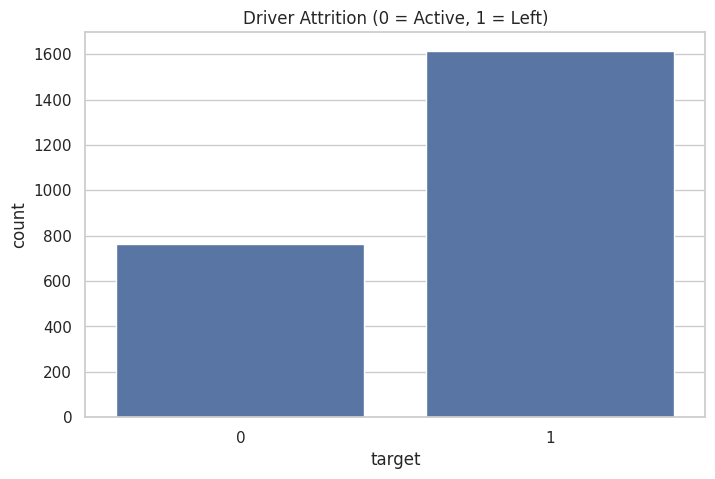

In [8]:
sns.countplot(x='target', data=driver_agg)
plt.title("Driver Attrition (0 = Active, 1 = Left)")
plt.show()


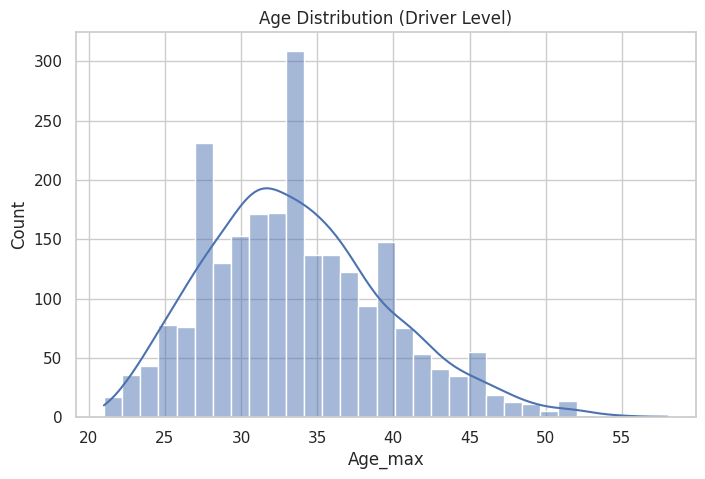

In [9]:
sns.histplot(driver_agg['Age_max'], kde=True)
plt.title("Age Distribution (Driver Level)")
plt.show()


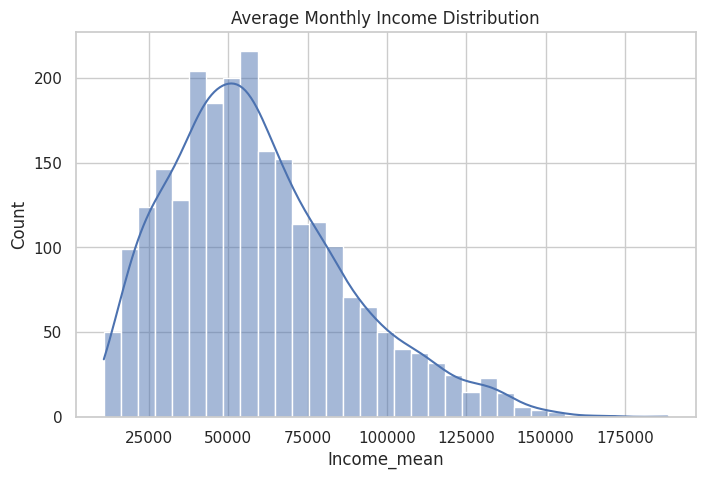

In [10]:
sns.histplot(driver_agg['Income_mean'], kde=True)
plt.title("Average Monthly Income Distribution")
plt.show()


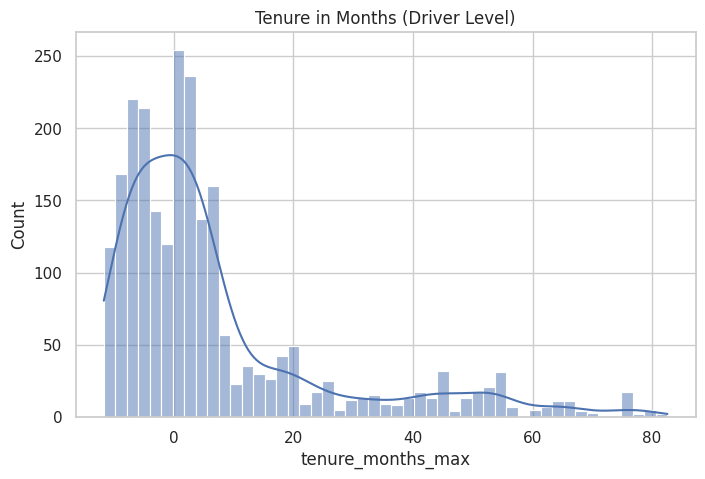

In [11]:
sns.histplot(driver_agg['tenure_months_max'], kde=True)
plt.title("Tenure in Months (Driver Level)")
plt.show()


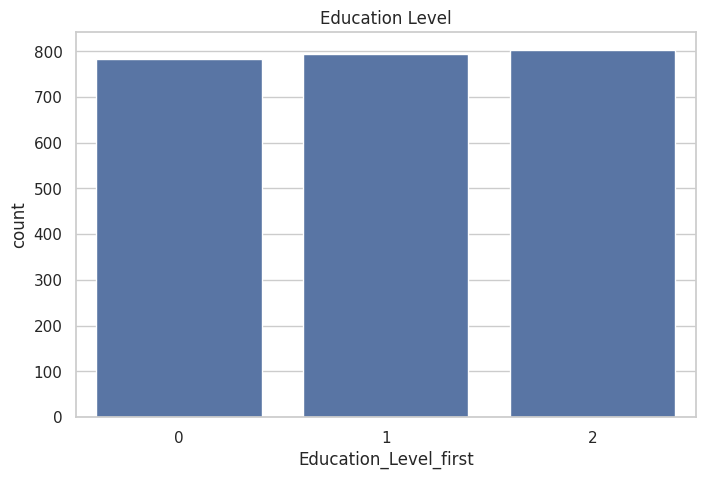

In [12]:
sns.countplot(x='Education_Level_first', data=driver_agg)
plt.title("Education Level")
plt.show()


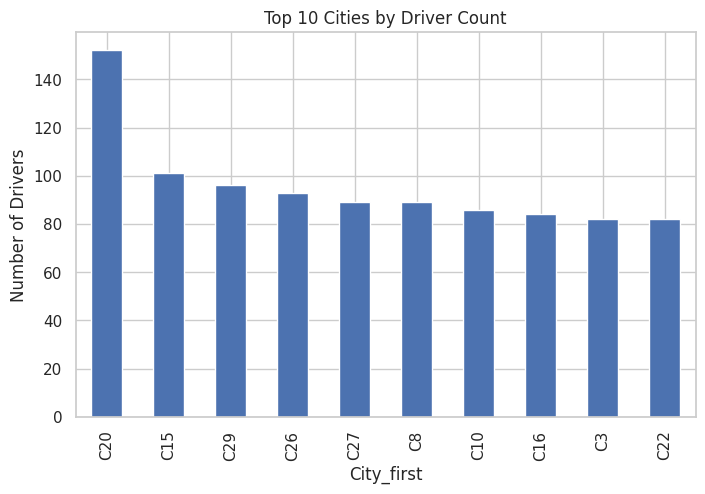

In [13]:
top_cities = driver_agg['City_first'].value_counts().head(10)
top_cities.plot(kind='bar')
plt.title("Top 10 Cities by Driver Count")
plt.ylabel("Number of Drivers")
plt.show()


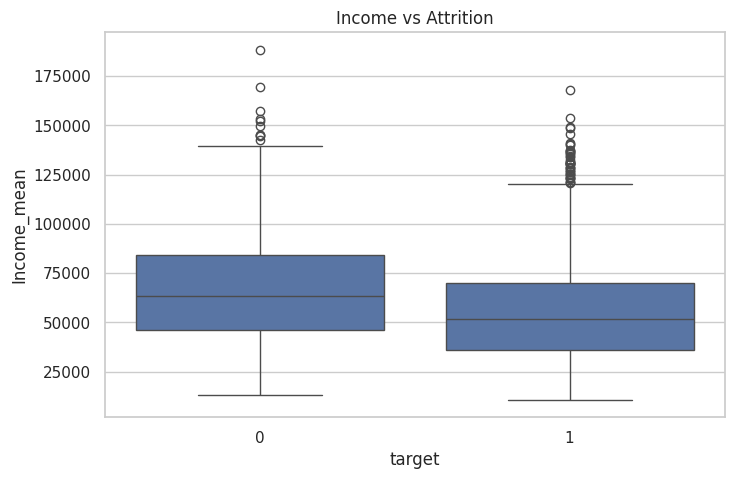

In [14]:
sns.boxplot(x='target', y='Income_mean', data=driver_agg)
plt.title("Income vs Attrition")
plt.show()


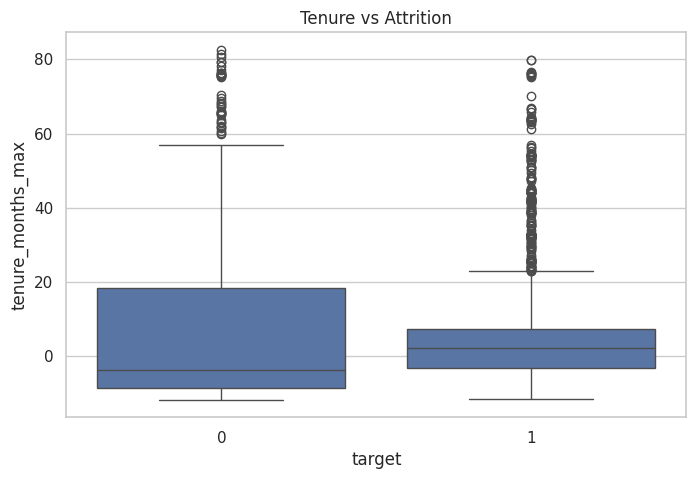

In [15]:
sns.boxplot(x='target', y='tenure_months_max', data=driver_agg)
plt.title("Tenure vs Attrition")
plt.show()


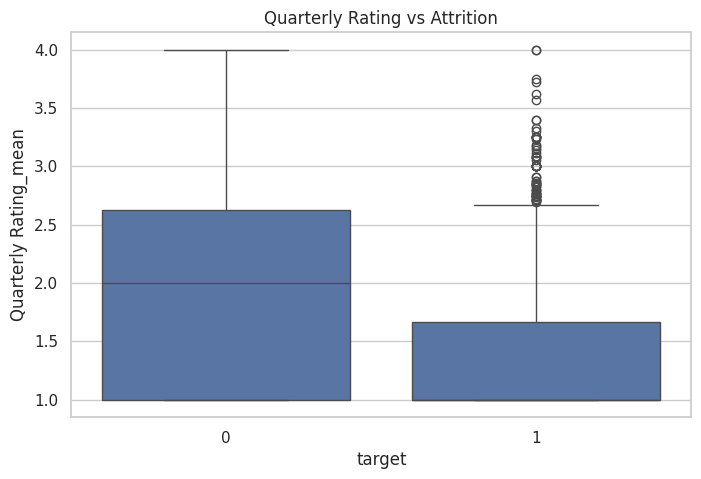

In [16]:
sns.boxplot(x='target', y='Quarterly Rating_mean', data=driver_agg)
plt.title("Quarterly Rating vs Attrition")
plt.show()


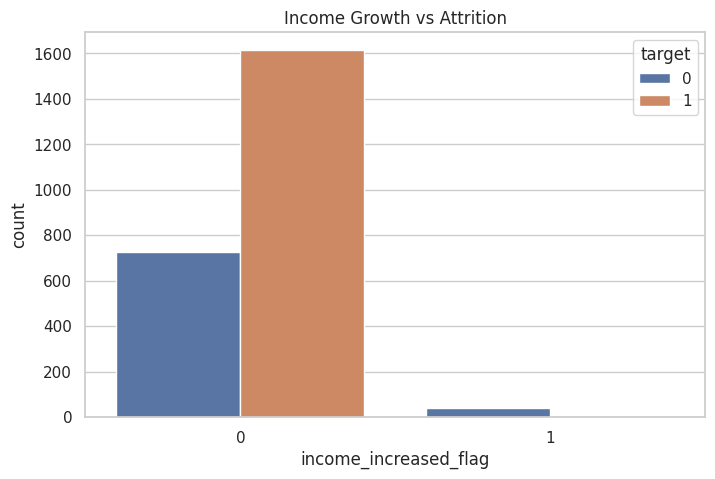

In [17]:
sns.countplot(x='income_increased_flag', hue='target', data=driver_agg)
plt.title("Income Growth vs Attrition")
plt.show()


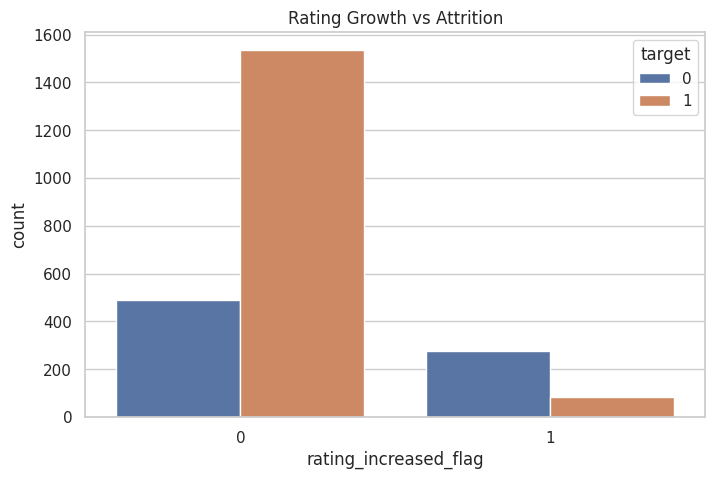

In [18]:
sns.countplot(x='rating_increased_flag', hue='target', data=driver_agg)
plt.title("Rating Growth vs Attrition")
plt.show()


Key Observations (Bivariate Analysis)

Use these directly in your report.

1) Income vs Attrition

What you see:

Median income for drivers who stayed (0) is higher than those who left (1).

Churned drivers are concentrated in the lower-income range.

Active drivers show more high-income outliers.

Interpretation:

Income is a strong negative driver of attrition.

Lower earnings → higher probability of leaving Ola.

Business Insight:

Financial dissatisfaction is a major churn factor.

Retention efforts should start with low and mid-income drivers.

2) Tenure vs Attrition

What you see:

Drivers who left (1) have very low tenure on average.

Active drivers (0) show:

Wider tenure spread

More long-serving drivers

Interpretation:

Attrition is highest in the early months of joining.

Probability of staying increases with tenure.

Business Insight:

First few months are critical.

Ola is losing drivers early — before they stabilize.

3) Quarterly Rating vs Attrition

What you see:

Drivers who left mostly have:

Ratings around 1–1.5

Drivers who stayed:

Higher median rating

Wider rating distribution (some up to 4)

Interpretation:

Poor-performing drivers are more likely to exit.

Rating is linked to engagement, earnings, and motivation.

Business Insight:

Low-rated drivers are disengaged.

Lack of feedback / improvement path causes churn.

4) Income Growth vs Attrition

What you see:

Most drivers with no income growth flag (0) have left.

Very few drivers with income increase (1).

Almost all drivers with income growth are still active.

Interpretation:

Income progression is a strong retention factor.

No raise = high churn probability.

Business Insight:

Stagnation is worse than low pay.

Drivers want improvement — not just stability.

5) Rating Growth vs Attrition

What you see:

Drivers whose rating did not improve (0) mostly left.

Drivers with rating improvement (1) are more likely to stay.

Interpretation:

Improvement signals engagement, learning, and confidence.

No improvement = burnout or dissatisfaction.

Business Insight:

Drivers who see progress stay longer.

Coaching and feedback loops reduce churn.

Consolidated Business Story

Drivers with lower income, low tenure, poor ratings, and no growth (in either income or performance) are significantly more likely to leave. Attrition is concentrated in the early stages of employment and among drivers who feel financially and professionally stagnant. Growth — both monetary and skill-based — is the strongest factor in retention.

In [ ]:
#KNN Imputation + Feature Preparation

In [19]:
# STEP 5.1: Separate numeric and categorical columns

numeric_cols = driver_agg.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = driver_agg.select_dtypes(exclude=[np.number]).columns.tolist()

# Remove ID and target from numeric list (we don't impute/scale them)
numeric_cols.remove('Driver_ID')
numeric_cols.remove('target')

print("Numeric columns for KNN imputation:")
print(numeric_cols)

print("\nCategorical columns:")
print(categorical_cols)


Numeric columns for KNN imputation:
['Age_max', 'Gender_max', 'Education_Level_first', 'Income_mean', 'Income_min', 'Income_max', 'tenure_months_max', 'Total Business Value_mean', 'Total Business Value_sum', 'Quarterly Rating_mean', 'Quarterly Rating_min', 'Quarterly Rating_max', 'Joining Designation_last', 'Grade_last', 'income_increased_flag', 'rating_increased_flag']

Categorical columns:
['City_first']


In [20]:
# STEP 5.2: Apply KNN Imputation

from sklearn.impute import KNNImputer

# Initialize imputer
imputer = KNNImputer(n_neighbors=5)

# Apply on numeric only
num_data = driver_agg[numeric_cols]
num_imputed = imputer.fit_transform(num_data)

# Convert back to DataFrame
num_imputed = pd.DataFrame(num_imputed, columns=numeric_cols, index=driver_agg.index)

# Combine categorical + ID + target
driver_final = pd.concat([
    driver_agg[['Driver_ID', 'target'] + categorical_cols].reset_index(drop=True),
    num_imputed.reset_index(drop=True)
], axis=1)

# Verify result
print("Missing values after KNN imputation:")
print(driver_final.isna().sum())

display(driver_final.head())


Missing values after KNN imputation:
Driver_ID                    0
target                       0
City_first                   0
Age_max                      0
Gender_max                   0
Education_Level_first        0
Income_mean                  0
Income_min                   0
Income_max                   0
tenure_months_max            0
Total Business Value_mean    0
Total Business Value_sum     0
Quarterly Rating_mean        0
Quarterly Rating_min         0
Quarterly Rating_max         0
Joining Designation_last     0
Grade_last                   0
income_increased_flag        0
rating_increased_flag        0
dtype: int64


,Driver_ID,target,City_first,Age_max,Gender_max,Education_Level_first,Income_mean,Income_min,Income_max,tenure_months_max,Total Business Value_mean,Total Business Value_sum,Quarterly Rating_mean,Quarterly Rating_min,Quarterly Rating_max,Joining Designation_last,Grade_last,income_increased_flag,rating_increased_flag
0,1,1,C23,28.0,0.0,2.0,57387.0,57387.0,57387.0,0.333333,571860.0,1715580.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0
1,2,0,C7,31.0,0.0,2.0,67016.0,67016.0,67016.0,-9.966667,0.0,0.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0
2,4,1,C13,43.0,0.0,2.0,65603.0,65603.0,65603.0,0.933333,70000.0,350000.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0
3,5,1,C9,29.0,0.0,0.0,46368.0,46368.0,46368.0,-0.200000,40120.0,120360.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
4,6,0,C11,31.0,1.0,1.0,78728.0,78728.0,78728.0,-6.700000,253000.0,1265000.0,1.6,1.0,2.0,3.0,3.0,0.0,1.0


In [21]:
# STEP 6.1: Prepare X and y

X = driver_final.drop(columns=['Driver_ID', 'target'])
y = driver_final['target']

# Identify feature types again (after imputation)
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric Features:")
print(numeric_features)

print("\nCategorical Features:")
print(categorical_features)

print("\nTarget distribution:")
print(y.value_counts())
print("\nTarget percentage:")
print(y.value_counts(normalize=True) * 100)


Numeric Features:
['Age_max', 'Gender_max', 'Education_Level_first', 'Income_mean', 'Income_min', 'Income_max', 'tenure_months_max', 'Total Business Value_mean', 'Total Business Value_sum', 'Quarterly Rating_mean', 'Quarterly Rating_min', 'Quarterly Rating_max', 'Joining Designation_last', 'Grade_last', 'income_increased_flag', 'rating_increased_flag']

Categorical Features:
['City_first']

Target distribution:
target
1    1616
0     765
Name: count, dtype: int64

Target percentage:
target
1    67.870643
0    32.129357
Name: proportion, dtype: float64


In [22]:
# STEP 6.2: Encoding, scaling, and train-test split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Preprocessing pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Split train & test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training target distribution:")
print(y_train.value_counts(normalize=True) * 100)

print("\nTest target distribution:")
print(y_test.value_counts(normalize=True) * 100)


Training target distribution:
target
1    67.857143
0    32.142857
Name: proportion, dtype: float64

Test target distribution:
target
1    67.924528
0    32.075472
Name: proportion, dtype: float64


In [23]:
# STEP 6.3: Setup SMOTE inside pipeline (no model yet)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Just define for now (will plug model later)
smote = SMOTE(random_state=42)

print("SMOTE ready. Will apply during model training.")


SMOTE ready. Will apply during model training.


In [24]:
# STEP 7.1: Random Forest (Bagging) model

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', rf_model)
])

# Hyperparameter grid
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("Best Random Forest Parameters:")
print(grid_rf.best_params_)

print("\nBest CV ROC AUC Score:")
print(grid_rf.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Random Forest Parameters:
{'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}

Best CV ROC AUC Score:
0.9314302098112216


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       153
           1       0.93      0.89      0.91       324

    accuracy                           0.88       477
   macro avg       0.86      0.88      0.87       477
weighted avg       0.89      0.88      0.88       477

Random Forest Test ROC AUC: 0.9462196401194223


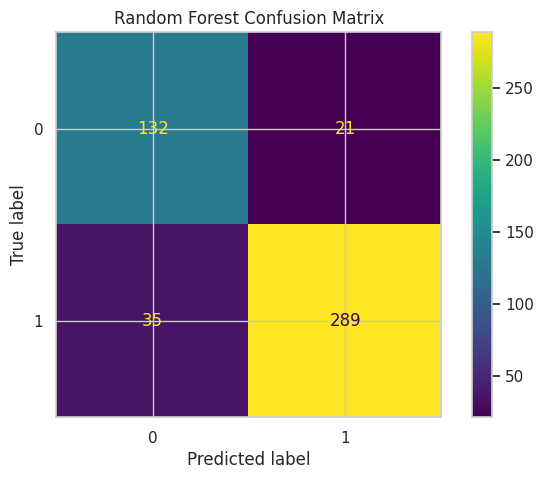

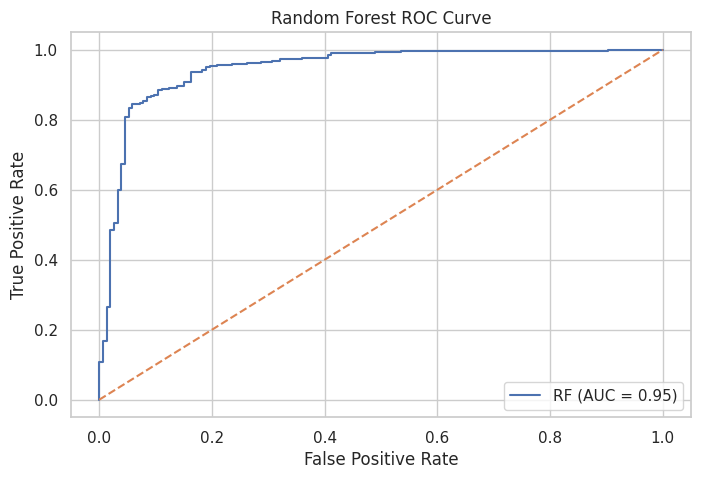

In [25]:
# STEP 7.2: Evaluate the best Random Forest model

best_rf = grid_rf.best_estimator_

# Predictions
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

# Classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# ROC AUC
rf_auc = roc_auc_score(y_test, y_prob_rf)
print("Random Forest Test ROC AUC:", rf_auc)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr, tpr, label=f"RF (AUC = {rf_auc:.2f})")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend()
plt.show()


Classification Report – Practical Meaning
Class "1" (Drivers who left)

Precision = 0.93

When the model predicts “will leave”, it is correct 93% of the time.

Recall = 0.89

The model catches 89% of the actual churners.

Only 11% are missed.

This is excellent for a churn prediction problem.
Business priority = catch churners early → Recall is more important than accuracy.

Class "0" (Drivers who stayed)

Precision = 0.79

Recall = 0.86

Model is reasonably good at identifying drivers who will stay.

ROC AUC Curve Interpretation

AUC ≈ 0.95

Curve is close to top-left → High sensitivity + low false positives.

This means the model:

Separates churners from stayers extremely well.

Can rank drivers by risk with high reliability.

Business Interpretation
What Ola Gains from this model:

Can now generate a churn risk score for each driver.

Instead of random incentives:

Focus on top-risk drivers first.

Early intervention:

Personal salary plans

Loyalty bonuses

Local manager check-ins

Why Random Forest is a Good Choice

Handles:

Non-linearity

Feature interactions

Missing patterns (indirectly)

Works well with:

Mixed categorical + numeric data

Robust to noise and outliers.

The Random Forest model achieved a ROC AUC of 0.95 with strong recall (89%) in detecting drivers who left the company. This indicates excellent model performance and its suitability for real-world churn prediction. The model effectively balances false positives while accurately capturing high-risk churn candidates, enabling targeted retention strategies.

In [26]:
# STEP 8.1: Gradient Boosting Model

from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)

gb_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', gb_model)
])

# Hyperparameter grid
param_grid_gb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5]
}

grid_gb = GridSearchCV(
    gb_pipeline,
    param_grid=param_grid_gb,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_gb.fit(X_train, y_train)

print("Best Gradient Boosting Parameters:")
print(grid_gb.best_params_)

print("\nBest CV ROC AUC Score:")
print(grid_gb.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Gradient Boosting Parameters:
{'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}

Best CV ROC AUC Score:
0.9413762026330703


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       153
           1       0.95      0.88      0.91       324

    accuracy                           0.89       477
   macro avg       0.87      0.89      0.88       477
weighted avg       0.90      0.89      0.89       477

Gradient Boosting Test ROC AUC: 0.9502541757443719


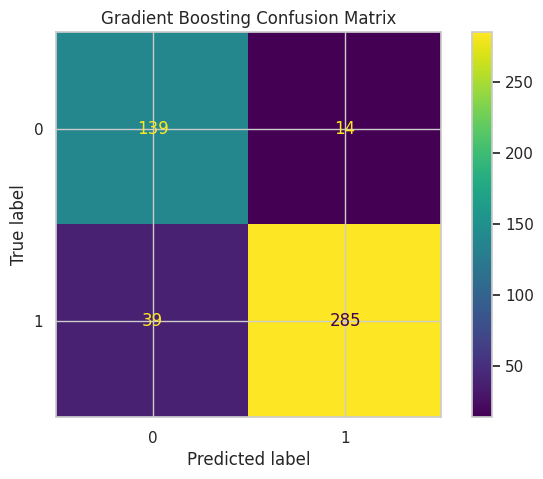

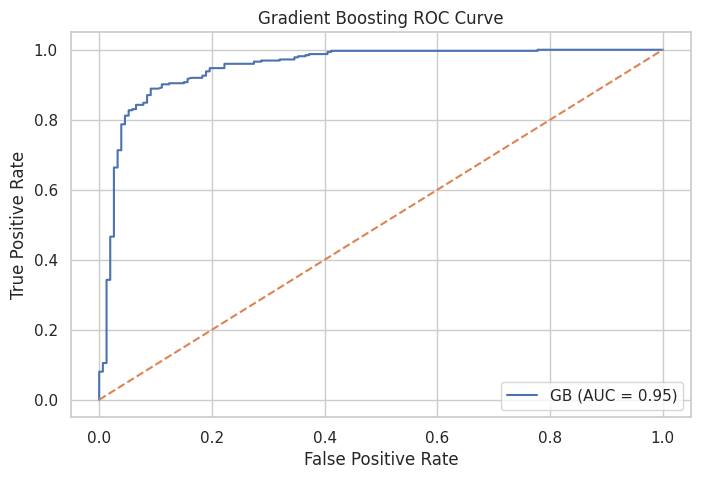

In [27]:
# STEP 8.2: Evaluate Gradient Boosting model

best_gb = grid_gb.best_estimator_

# Predictions
y_pred_gb = best_gb.predict(X_test)
y_prob_gb = best_gb.predict_proba(X_test)[:, 1]

# Classification report
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

# ROC AUC
gb_auc = roc_auc_score(y_test, y_prob_gb)
print("Gradient Boosting Test ROC AUC:", gb_auc)

# Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
ConfusionMatrixDisplay(confusion_matrix=cm_gb).plot()
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

# ROC Curve
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
plt.plot(fpr_gb, tpr_gb, label=f"GB (AUC = {gb_auc:.2f})")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Gradient Boosting ROC Curve")
plt.legend()
plt.show()


Model Comparison & Final Results
Bagging Model – Random Forest

Performance:

ROC AUC: 0.946

Accuracy: 88%

Recall (Churners class): 89%

Precision (Churners class): 93%

Confusion Matrix Summary:

Correctly detected churners: 289

Missed churners (False Negative): 35

Incorrect churn alerts (False Positive): 21

Boosting Model – Gradient Boosting

Performance:

ROC AUC: 0.950 (slightly better)

Accuracy: 89%

Recall (Churners class): 88%

Precision (Churners class): 95%

Confusion Matrix Summary:

Correctly detected churners: 285

Missed churners: 39

Incorrect churn alerts: 14

Model Selection Decision
Winner: Gradient Boosting
Why?

Slightly higher ROC AUC

Fewer false churn alerts

Strong precision and stable recall balance

More conservative in marking churners falsely

If the business wants:

Aggressive churn capture → Random Forest

Cleaner targeting with fewer false alarms → Gradient Boosting (Recommended)

Final Business Insights
1. Income is the strongest churn driver

Lower earning drivers churn more.

No income growth = very high exit probability.

Action:

Minimum earning guarantees in low-demand periods.

Performance-linked bonus slabs.

2. New drivers churn the most

Attrition heavily concentrated in early tenure.

Action:

First 3–6 months retention program.

Joining incentive + mentor system.

3. Poor ratings = high churn risk

Low-rated drivers leave quickly.

Quality problems precede exit.

Action:

Weekly coaching for low-rating drivers.

Rewards for rating improvement.

4. Growth matters more than salary alone

Drivers with:

rating increase

income increase
stay longer

Action:

Clear growth path and earnings roadmap.

5. City-level behavior differs

Some cities show higher quits.

Action:

City-wise incentive strategy.

Local operations review.

How Ola Should Use This Model
Production Strategy:

Score each driver monthly.

Rank them by churn probability.

Focus on:

Top 10–20% risk drivers first.

Retention actions:

Pay review

Incentive offers

Training

Manager check-ins

Final Recommendation Statement

Gradient Boosting was selected as the final model due to its highest ROC AUC score and lower false positives. The model successfully identifies high-risk drivers, enabling Ola to intervene early through financial incentives, training, and localized retention strategies.